**In** this notebook we will perform time series forecasting including both univariate and multivariate data using different models. The dataset we are using is of air pollution from 2010 to 2014. 

In [2]:
!pip install fbprophet

^C


## Import the necessary libraries

In [1]:
import warnings
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from fbprophet import Prophet
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'fbprophet'

## Loading the dataset

In [ ]:
air_pollution = pd.read_csv('Air_Pollutions.csv', parse_dates=['date'])
air_pollution.dropna(inplace = True)
air_pollution.set_index('date', inplace=True)  # setting date as index
air_pollution.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


In [ ]:
air_pollution.describe()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,98.245080,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,98.245080
std,76.807697,14.163508,11.552997,10.076053,41.373161,0.546072,0.993917,76.807697
min,3.166667,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000,3.166667
25%,42.333333,-10.083333,1.541667,1007.916667,5.904167,0.000000,0.000000,42.333333
50%,79.166667,2.041667,13.916667,1016.208333,10.953750,0.000000,0.000000,79.166667
75%,131.166667,15.083333,23.166667,1024.541667,22.235000,0.000000,0.000000,131.166667
max,541.895833,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333,541.895833


In [ ]:
air_pollution_df = air_pollution[['pollution_today']] 
air_pollution_df.head(10)

,pollution_today
date,
2010-01-02,145.958333
2010-01-03,78.833333
2010-01-04,31.333333
2010-01-05,42.458333
2010-01-06,56.416667
2010-01-07,69.000000
2010-01-08,176.208333
2010-01-09,88.500000
2010-01-10,57.250000


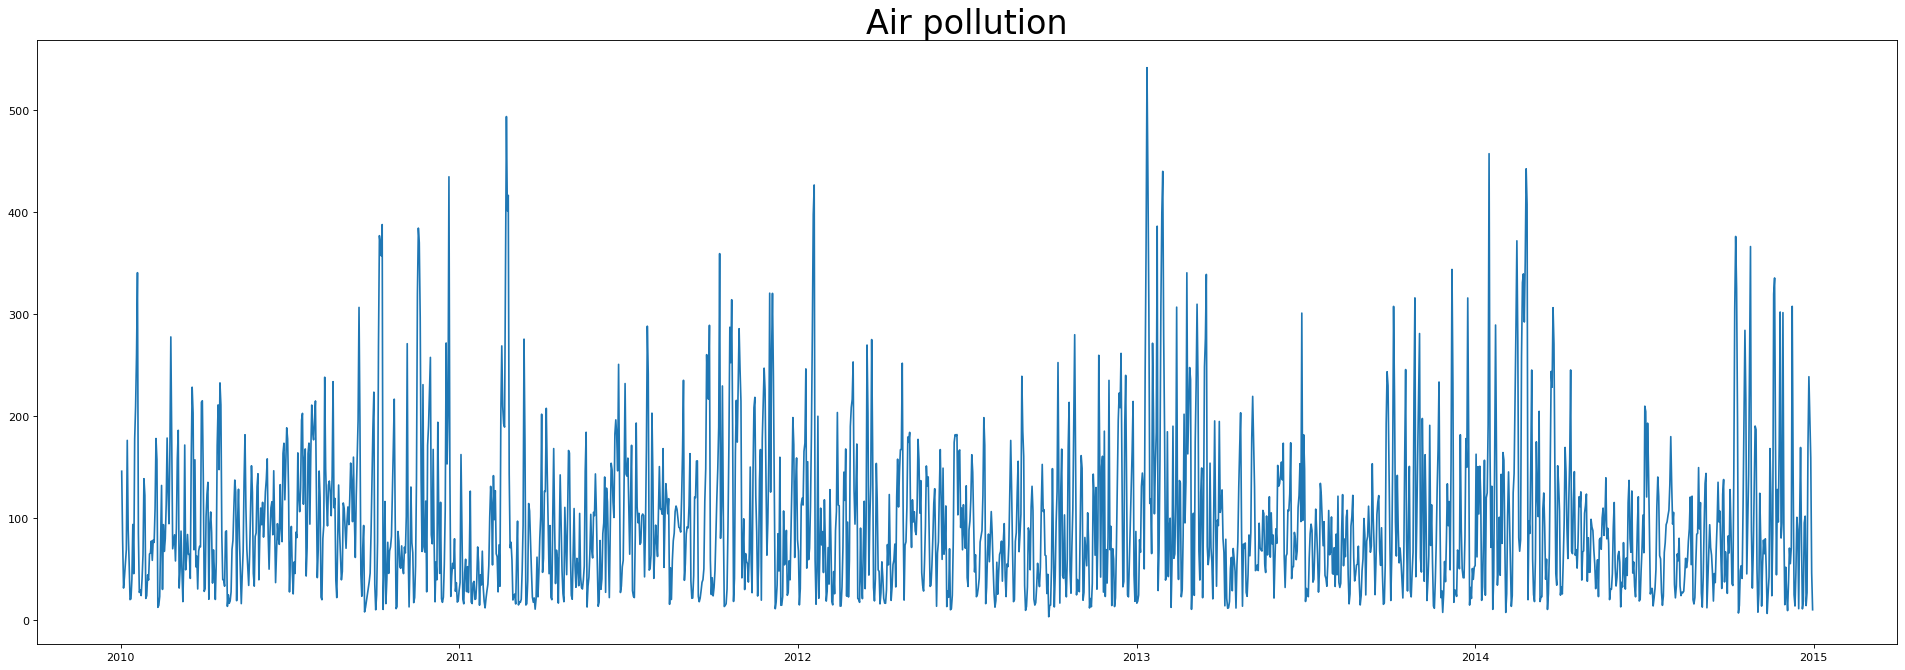

In [ ]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution', fontsize=30)

plt.plot(air_pollution_df.pollution_today)

A probability distribution can also be used to illustrate the data in our series.

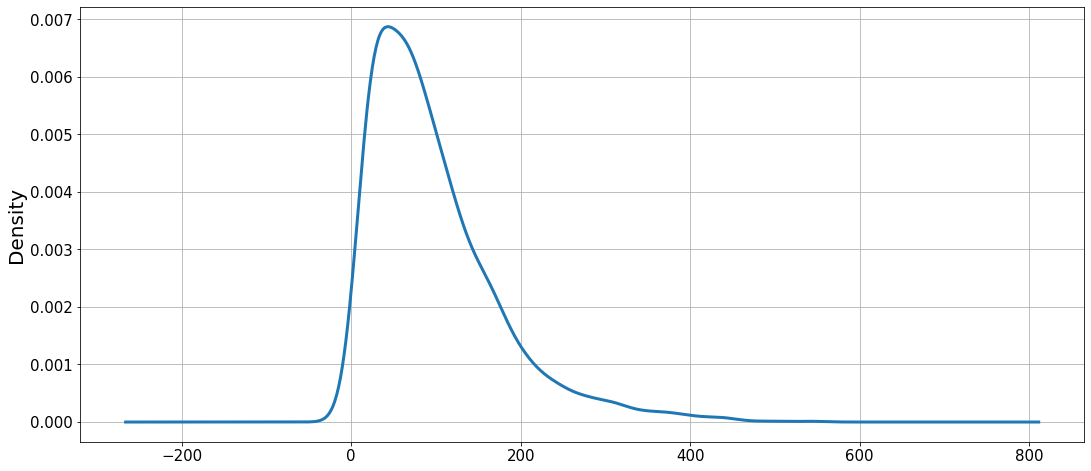

In [ ]:
# Distribution of the pollution  
pollution_today = air_pollution_df.pollution_today 
pollution_today.plot(kind='kde',figsize = (18,8), linewidth= 3) 
plt.xticks(fontsize = 15)
plt.grid("both")
plt.ylabel('Density', fontsize = 20)
plt.yticks(fontsize = 15)
plt.show()

## Check for stationarity

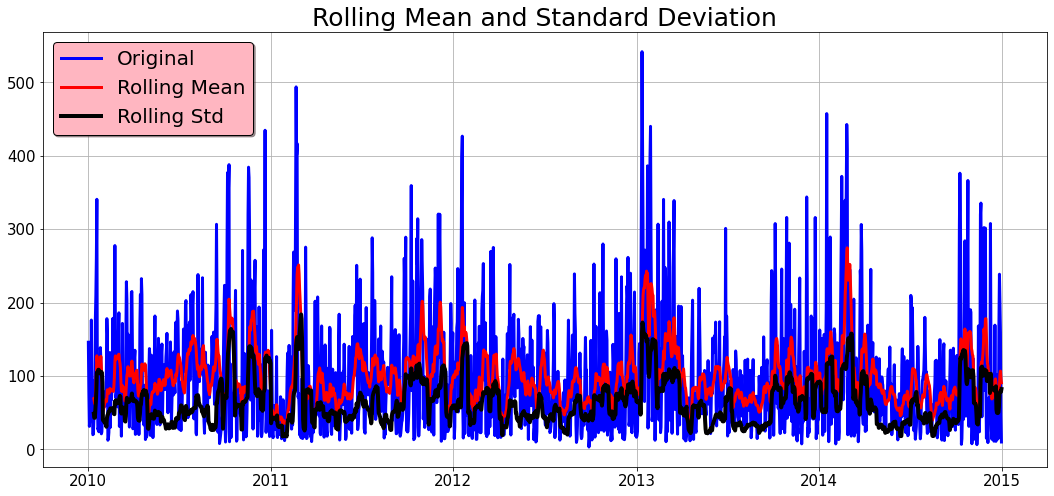

Results of dickey fuller test
Test Statistics               -1.011672e+01
p-value                        9.680895e-18
No. of lags used               1.200000e+01
Number of observations used    1.812000e+03
critical value (1%)           -3.433964e+00
critical value (5%)           -2.863136e+00
critical value (10%)          -2.567620e+00
dtype: float64


In [ ]:

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() # rolling mean
    rolstd = timeseries.rolling(12).std() # rolling standard deviation
    # Plot rolling statistics:
    plt.figure(figsize = (18,8))
    plt.grid('both')
    plt.plot(timeseries, color='blue',label='Original', linewidth = 3)
    plt.plot(rolmean, color='red', label='Rolling Mean',linewidth = 3)
    plt.plot(rolstd, color='black', label = 'Rolling Std',linewidth = 4)
    plt.legend(loc='best', fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
    plt.title('Rolling Mean and Standard Deviation', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(pollution_today)

We can reject the Null hypothesis because the p-value is less than 0.05. Furthermore, the test statistics is less than critical values. As a result, the data is stationary.

<Figure size 432x288 with 0 Axes>

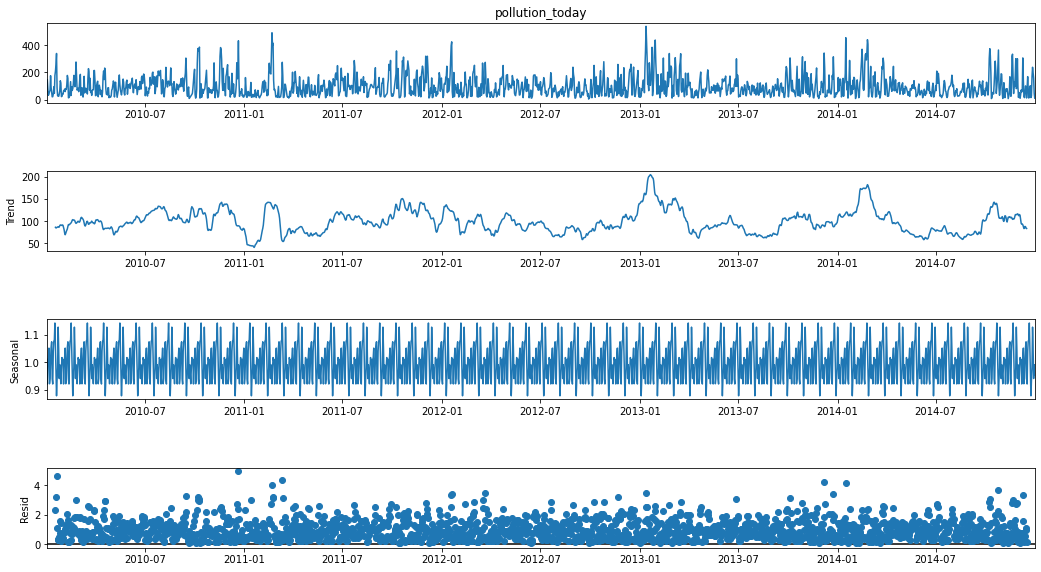

In [ ]:
result = seasonal_decompose(pollution_today, model='multiplicative', freq = 30)
fig = plt.figure()
fig = result.plot()  
fig.set_size_inches(16, 9)

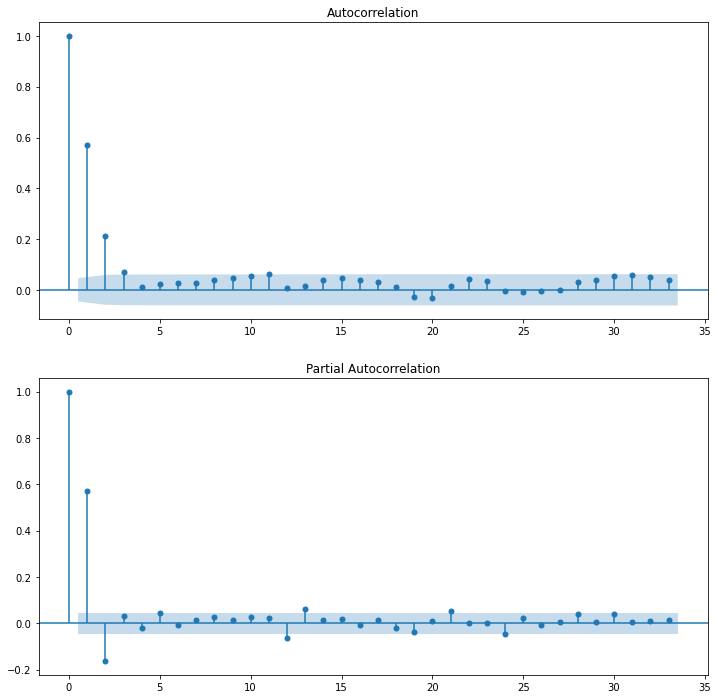

In [ ]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = plot_acf(pollution_today, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(pollution_today, ax=ax2)

## Implementing different Methods for time series forecasting


There are various approaches for time series forecasting that we can utilise, and there is no distinct winner. The model you use should always be based on how your data looks and what you're attempting to accomplish.

In this notebook we will implement following models : 

- **Univariate Time Series Forecasting**
    - Simple Exponential Smoothing (SES) 
    - Holt Winter’s Exponential Smoothing (HWES)
    - Autoregression (AR)
    - Autoregressive Moving Average (ARMA)
    - Prophet

- **Multivariate Time Series Forecasting**
    - Vector Autoregression (VAR)
    - Vector Autoregression Moving-Average with Exogenous Regressors (VARMA)



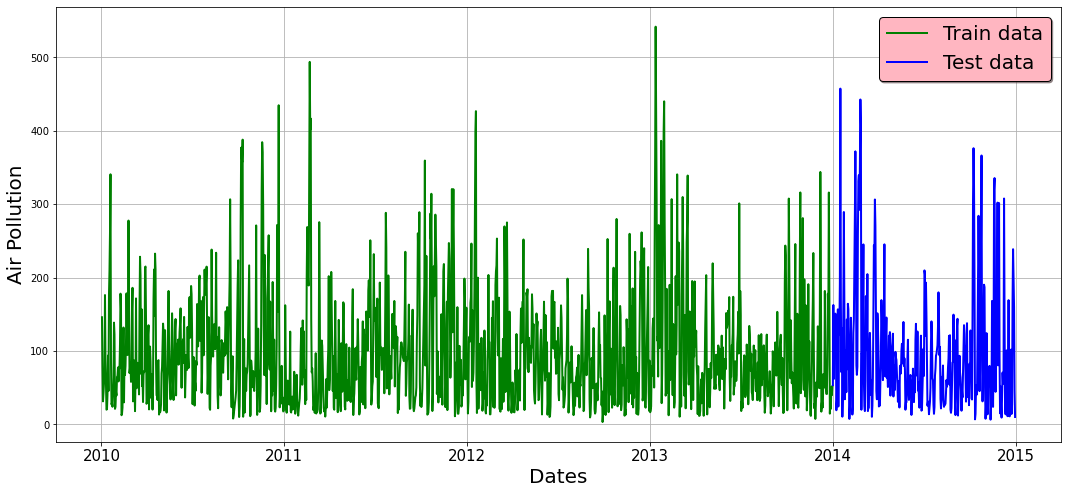

In [ ]:
#split data into train and training set
train_data=pollution_today[0:-365] # we are taking 2014 data as test data
test_data=pollution_today[-365:]
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Dates', fontsize = 20)
plt.ylabel('Air Pollution', fontsize = 20)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.plot(train_data, 'green', label='Train data', linewidth = 2)
plt.plot(test_data, 'blue', label='Test data', linewidth = 2)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')

### Simple Exponential Smoothing (SES) 

When the data does not meet any of the following rules, Simple Exponential Smoothing is used to predict time series: 

1. Trend: An upward or downward slope
2. Seasonality: Shows a particular pattern due to seasonal factors like Hours, days, Year, etc.

SES uses weighted averages, which are the averages of prior levels and current observations. The largest weights correspond to the most recent observations, while the smallest weights correspond to the oldest observations.

The smoothing parameter, which is known as (alpha) in this case, controls the weight loss. The value of (alpha) can range from 0 to 1:

- (alpha)=0: This indicates that the projection for future value is based on an average of historical data.
- (alpha)=1: This indicates that the forecast for all future values is equal to the value of the most recent observation.

In [ ]:
history = [x for x in train_data]
predictions = list()
for t in range(len(test_data)):
    model = SimpleExpSmoothing(history)
    model_fit = model.fit()
    pred = model_fit.predict()
    predictions.append(pred)
    history.append(test_data[t])
ses = np.sqrt(mean_squared_error(test_data, predictions))
print('RMSE of SES Model:', ses)

RMSE of SES Model: 74.56968648007373


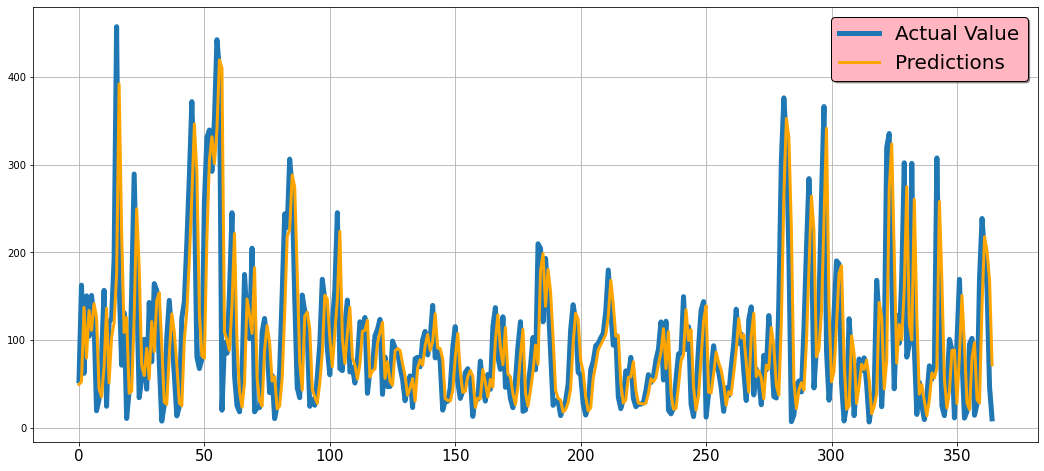

In [ ]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_data)),test_data, label = 'Actual Value', linewidth = 5)
plt.plot(range(len(predictions)), predictions, label = 'Predictions', linewidth = 3, color = 'orange')
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()


### Holt Winter’s Exponential Smoothing (HWES)

Holt-Winters Exponential Smoothing (HWES) is a method for smoothing the results of a Univariate Time Series Analysis so that they can be used to forecast future values. The objective is to give more weight to more recent instances by assigning exponentially declining weights. When a result, as we go back in time, we'll witness decreasing weights.

In [ ]:
history = [x for x in train_data]
predictions = list()
for t in range(len(test_data)):
    model = ExponentialSmoothing(history)
    model_fit = model.fit()
    pred = model_fit.predict()
    predictions.append(pred)
    history.append(test_data[t])
hwes = np.sqrt(mean_squared_error(test_data, predictions))
print('RMSE of HWES Model:', hwes)

RMSE of HWES Model: 74.5697152356565


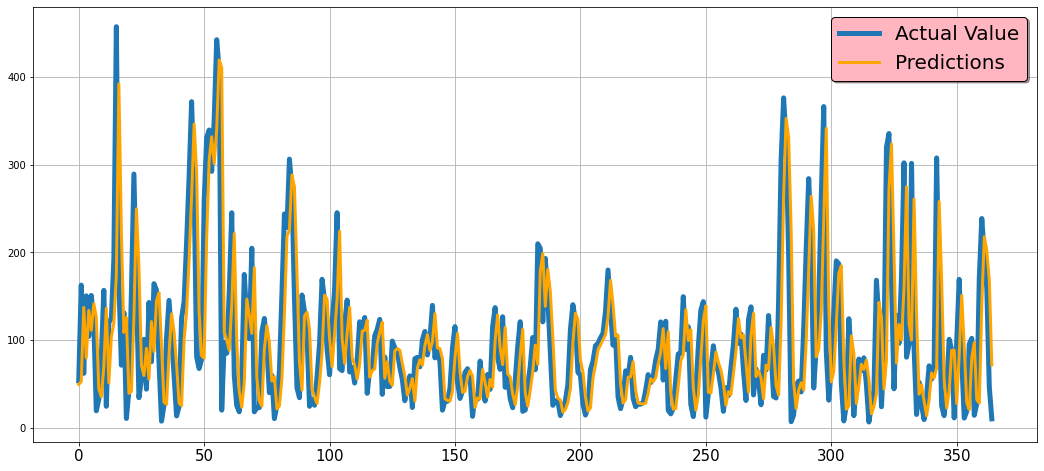

In [ ]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_data)),test_data, label = 'Actual Value', linewidth = 5)
plt.plot(range(len(predictions)), predictions, label = 'Predictions', linewidth = 3, color = 'orange')
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

### Autoregression (AR)

In an autoregression model, we use a linear combination of the variable's historical values to forecast the variable of interest. The word autoregression denotes that the variable is being regressed against itself.

p is the parameter related with the auto-regressive element of the model, which integrates past values i.e. lags of the dependent variable. If p is 5, for example, the predictors for x(t) will be x(t-1)....x (t-5).

In [ ]:
history = [x for x in train_data]
predictions = list()
for t in range(len(test_data)):
    model = AR(history)
    model_fit = model.fit()
    pred = model_fit.predict(start=len(history), end=len(history), dynamic=False)
    predictions.append(pred)
    history.append(test_data[t])
ar = np.sqrt(mean_squared_error(test_data, predictions))
print('RMSE of AR Model:', ar)

RMSE of AR Model: 65.24348674603769


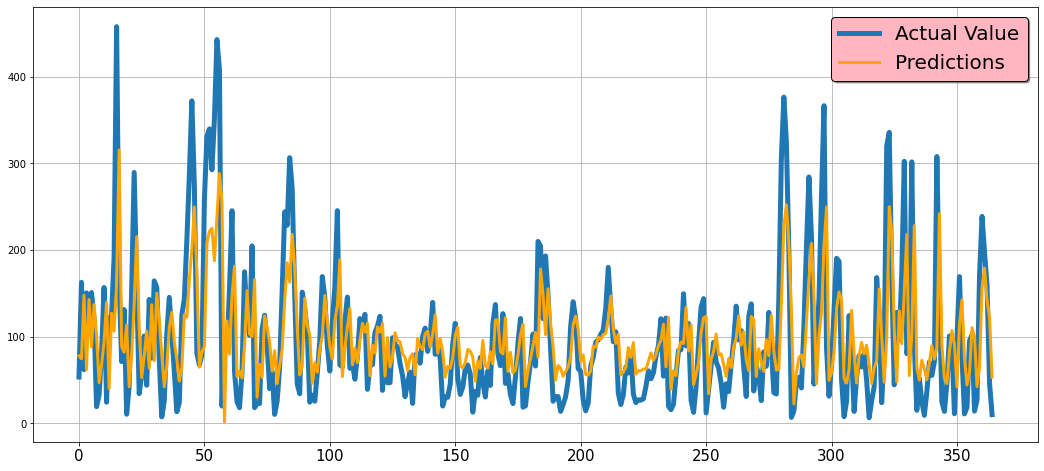

In [ ]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_data)),test_data, label = 'Actual Value', linewidth = 5)
plt.plot(range(len(predictions)), predictions, label = 'Predictions', linewidth = 3, color = 'orange')
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

### Autoregressive Moving Average (ARMA)

ARMA is a forecasting model in which the methods of autoregression (AR) analysis and moving average (MA) are both used on well-behaved time-series data. The time series is believed to be stationary in ARMA, and when it fluctuates, it does so uniformly around a specific time.

- **Number of AR (Auto-Regressive) terms (p):** p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- **Number of MA (Moving Average) terms (q):** q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

In [ ]:
history = [x for x in train_data]
predictions = list()
for t in range(len(test_data)):
    model = ARMA(history, order=(1, 3))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(history), end=len(history), dynamic=False)
    predictions.append(pred)
    history.append(test_data[t])
ar = np.sqrt(mean_squared_error(test_data, predictions))
print('RMSE of AR Model:', ar)


RMSE of AR Model: 64.70104245388164


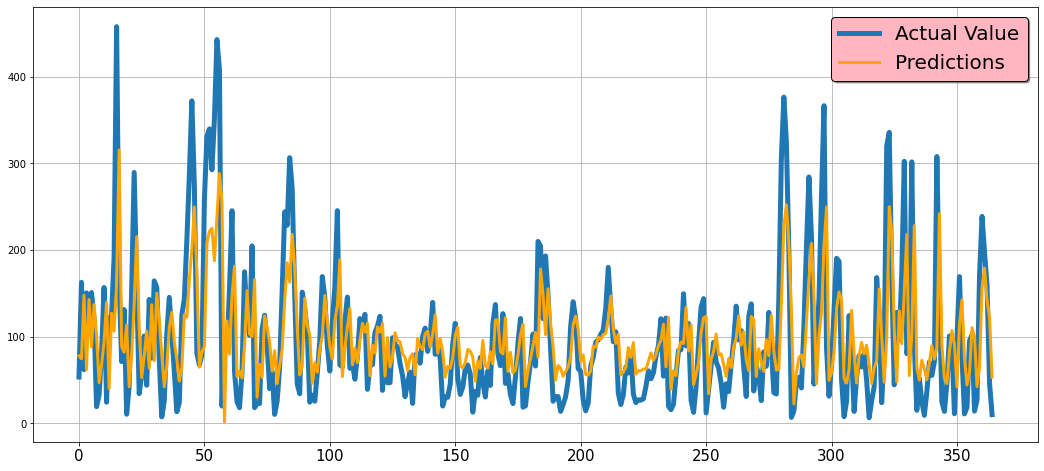

In [ ]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_data)),test_data, label = 'Actual Value', linewidth = 5)
plt.plot(range(len(predictions)), predictions, label = 'Predictions', linewidth = 3, color = 'orange')
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

### Prophet

FbProphet is "released by Core Data Science Team at Facebook. Prophet is a time series data forecasting process based on an additive model that fits non-linear trends with yearly, weekly, and daily seasonality, as well as holiday impacts. It works best with time series with substantial seasonal influences and historical data from multiple seasons. Prophet is forgiving of missing data and trend shifts, and it usually handles outliers well.


In [ ]:
# Prophet needs some specifics data stuff, coment it here
prophet_data = air_pollution_df.rename(columns={'pollution_today': 'y'}) 
prophet_data['ds'] = prophet_data.index
prophet_data.index = pd.RangeIndex(len(prophet_data.index))

# split data into train and test set
prophet_train_data=f

In [ ]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
).add_country_holidays(country_name='China')

In [ ]:
prophet.fit(prophet_train_data)
predictions = prophet.predict(prophet_test_data)
prophet = np.sqrt(mean_squared_error(test_data, predictions['yhat']))
print('RMSE of Prophet Model:', ar)

RMSE of Prophet Model: 64.78430351508776


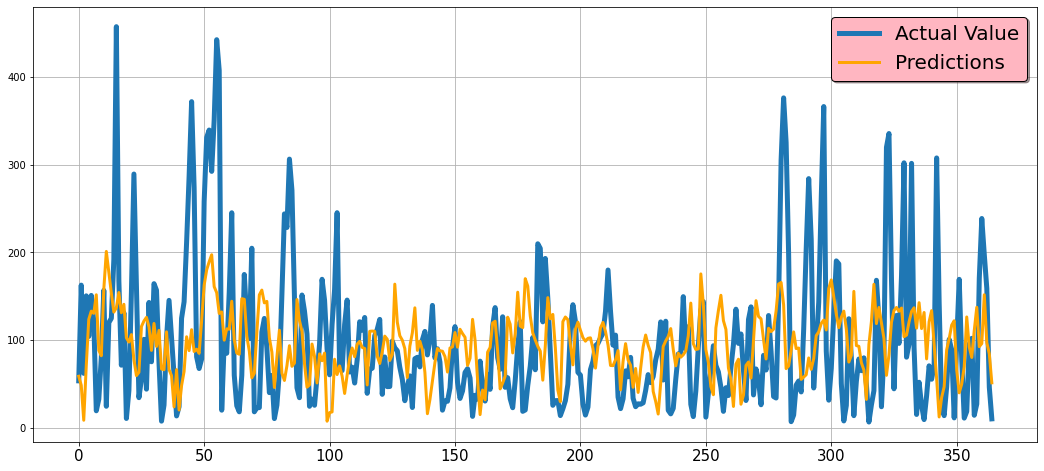

In [ ]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_data)),test_data, label = 'Actual Value', linewidth = 5)
plt.plot(range(len(predictions)), predictions['yhat'], label = 'Predictions', linewidth = 3, color = 'orange')
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

### Vector Autoregression (VAR)
The Vector Autoregression (VAR) method models the next step in each time series using an AR model. It is the generalization of AR to multiple parallel time series, e.g. multivariate time series.

The notation for the model involves specifying the order for the AR(p) model as parameters to a VAR function, e.g. VAR(p).

The method is suitable for multivariate time series without trend and seasonal components.

In [ ]:
# For multivariate time series forecasting, we are using two features pollution today and wind speed.
air_pollution = air_pollution[['pollution_today','wnd_spd']] 

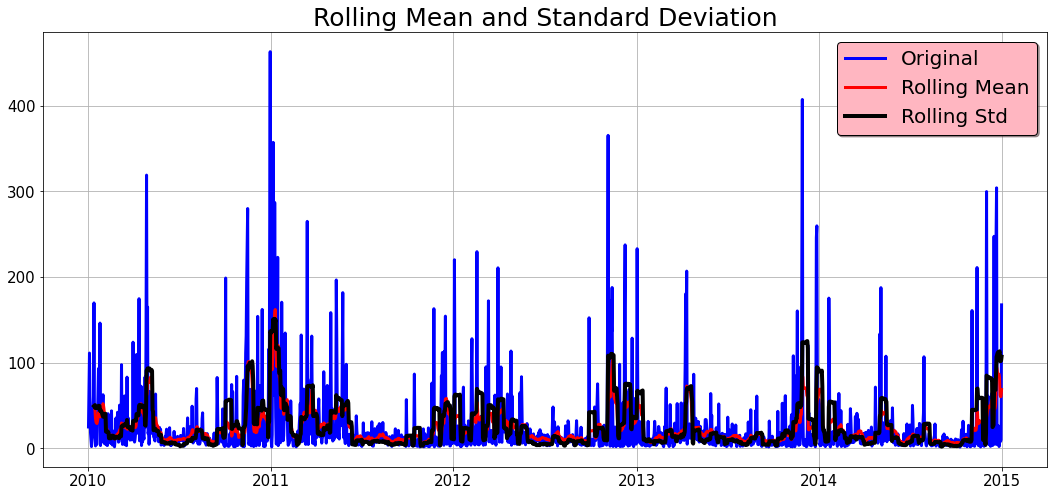

Results of dickey fuller test
Test Statistics               -1.020183e+01
p-value                        5.942703e-18
No. of lags used               8.000000e+00
Number of observations used    1.816000e+03
critical value (1%)           -3.433956e+00
critical value (5%)           -2.863133e+00
critical value (10%)          -2.567618e+00
dtype: float64


In [ ]:
# checking if wind speed series is stationary or not
test_stationarity(air_pollution['wnd_spd']) 

In [ ]:
train = air_pollution[:-100]
test = air_pollution[-100:]

In [ ]:
aic = list() 
for i in range(20):
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
print('Best VAR({})'.format(aic.index(min(aic))))

Best VAR(13)


In [ ]:
history = train
predictions = list()
for t in range(len(test)):
    model = VAR(history)
    model_fit = model.fit(13)
    pred = model_fit.forecast(model_fit.y, steps = 1)
    predictions.append(pred)
    history = history.append(test.iloc[t:t+1,:])
prediction_1 = []
prediction_2 = []
for pred in predictions:
    prediction_1.append(pred[0][0])
    prediction_2.append(pred[0][1])
var_1 = np.sqrt(mean_squared_error(test['pollution_today'], prediction_1))
print('RMSE of VAR Model:', var_1)
var_2 = np.sqrt(mean_squared_error(test['wnd_spd'], prediction_2))
print('RMSE of VAR Model:', var_2)

RMSE of VAR Model: 77.78633367533595
RMSE of VAR Model: 58.012807336064


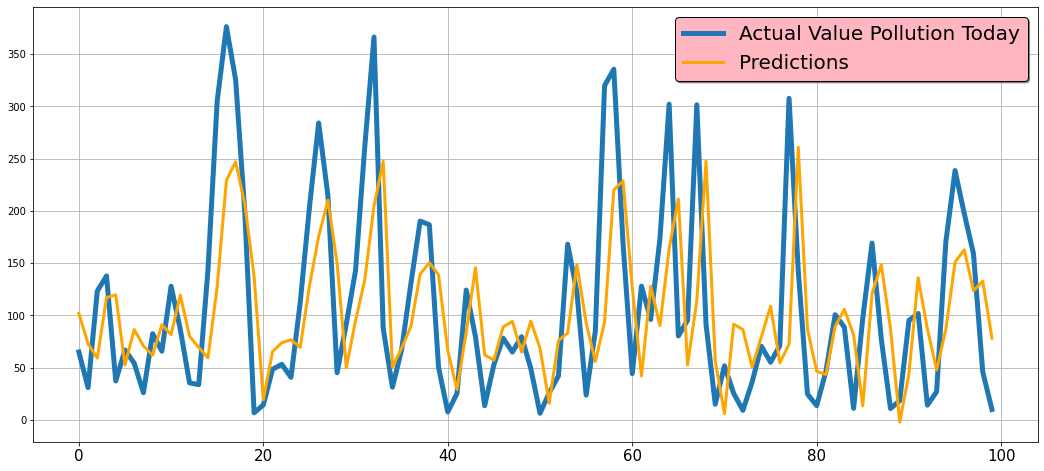

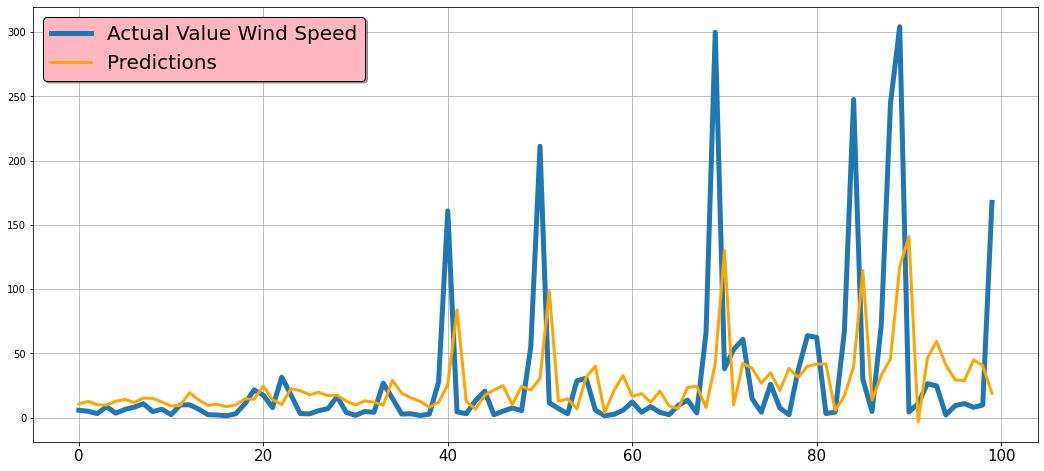

In [ ]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test['pollution_today'])),test['pollution_today'], label = 'Actual Value Pollution Today', linewidth = 5)
plt.plot(range(len(prediction_1)), prediction_1, label = 'Predictions', linewidth = 3, color = 'orange')
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test['wnd_spd'])),test['wnd_spd'], label = 'Actual Value Wind Speed', linewidth = 5)
plt.plot(range(len(prediction_2)), prediction_2, label = 'Predictions', linewidth = 3, color = 'orange')
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

### Vector Autoregression Moving-Average with Exogenous Regressors (VARMA)


The Vector Autoregressive Moving Average(VARMA) model is a combination of VAR and VMA models that helps in multivariate time series modelling by considering both lag order and order of moving average (p and q)in the model. We can make a VARMA model act like a VAR model by just setting the q parameter as 0 and it also can act like a VMA model by just setting the p parameter as 0. 


In [ ]:
train = air_pollution[:-30]
test = air_pollution[-30:]
history = train
predictions = list()
for t in range(len(test)):
    model = VARMAX(history, order = (2,1))
    model_fit = model.fit()
    pred = model_fit.forecast(steps = 1)
    predictions.append(pred)
    history = history.append(test.iloc[t:t+1,:])
prediction_1 = []
prediction_2 = []
for pred in predictions:
    prediction_1.append(pred['pollution_today'][0])
    prediction_2.append(pred['wnd_spd'][0])
varma_1 = np.sqrt(mean_squared_error(test['pollution_today'], prediction_1))
print('RMSE of VARMA Model:', varma_1)
varma_2 = np.sqrt(mean_squared_error(test['wnd_spd'], prediction_2))
print('RMSE of VARMA Model:', varma_2)

RMSE of VARMA Model: 65.83817648226388
RMSE of VARMA Model: 78.87032958157994


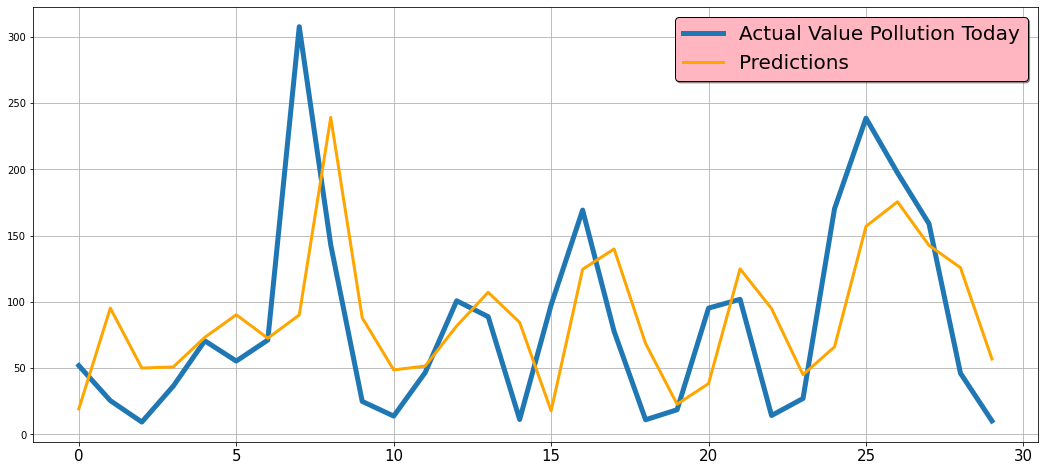

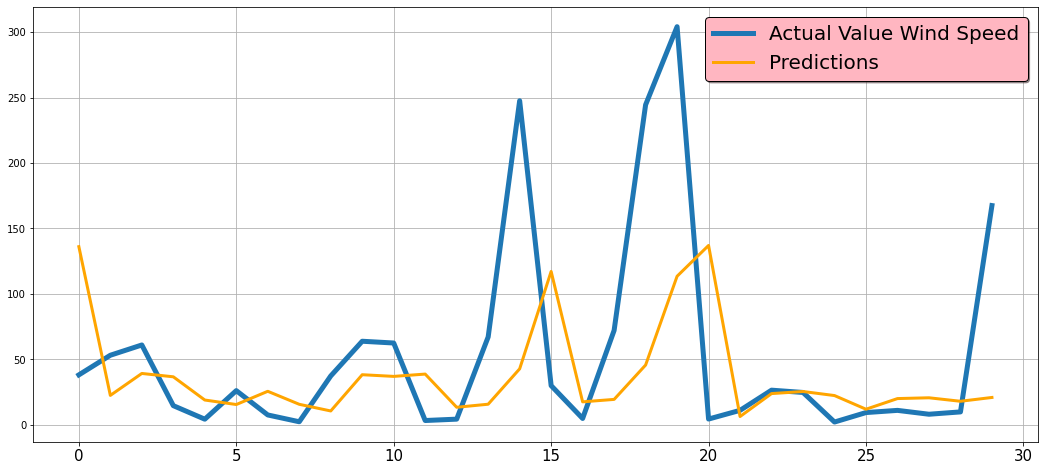

In [ ]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test['pollution_today'])),test['pollution_today'], label = 'Actual Value Pollution Today', linewidth = 5)
plt.plot(range(len(prediction_1)), prediction_1, label = 'Predictions', linewidth = 3, color = 'orange')
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()

plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test['wnd_spd'])),test['wnd_spd'], label = 'Actual Value Wind Speed', linewidth = 5)
plt.plot(range(len(prediction_2)), prediction_2, label = 'Predictions', linewidth = 3, color = 'orange')
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
plt.show()